# South Korea Qiskit Hackathon'20 - Qiskit Metal exercise

## Preparation

In [1]:
%load_ext autoreload
%autoreload 2

*Make sure to have the right kernel selected!*

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs

%metal_heading Welcome to Qiskit Metal!

Welcome to Qiskit Metal! 

For this example tutorial, we will attempt to create a simple two qubit chip. We will want to generate the layout, simulate/analyze and tune the chip to hit the parameters we are wanting, finally rendering to a GDS file.

One could generate subsections of the layout and tune individual components first, but in this case we will create all of the layout. We will want a transmon (in this case choosing ones with charge lines), meandered and simple transmission lines, capacitor couplers, and launchers for wirebond connections. So we will import these, and also create a design instance and launch the GUI.

## Design the layout

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket_cl import TransmonPocketCL

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder

from qiskit_metal.qlibrary.lumped.cap_3_interdigital import Cap3Interdigital
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

In [4]:
design = metal.designs.DesignPlanar()
gui = metal.MetalGUI(design)

Since we are likely to be making many changes while tuning and modifying our design, we will enable overwriting. We can also check all of the chip properties to see if we want to change the size or any other parameter.

In [5]:
design.overwrite_enabled = True
design.chips.main

{'material': 'silicon',
 'layer_start': '0',
 'layer_end': '2048',
 'size': {'center_x': '0.0mm',
  'center_y': '0.0mm',
  'center_z': '0.0mm',
  'size_x': '9mm',
  'size_y': '6mm',
  'size_z': '-750um',
  'sample_holder_top': '890um',
  'sample_holder_bottom': '1650um'}}

We will add the two qubits. We know we will want each qubit to have two connection pads, one for readout, and another for the connection to the other qubit. We can see any options the qubit qcomponent has to figure out what we might want to modify when creating the component. This will include the components default options (which the component designer included) as well as renderer options (which are added based on what renderers are present in Metal).

In [6]:
TransmonPocketCL.get_template_options(design)

{'pos_x': '0um',
 'pos_y': '0um',
 'connection_pads': {},
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'},
 'chip': 'main',
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'orientation': '0',
 'make_CL': True,
 'cl_gap': '6um',
 'cl_width': '10um',
 'cl_length': '20um',
 'cl_ground_gap': '6um',
 'cl_pocket_edge': '0',
 'cl_off_center': '50um',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name': 'my_other_junction'

We will then add those two qubits with the options we are wanting to define, these can all be modified easily later too.
The rebuild command is included so the changes can be seen immediately in the GUI.

In [7]:
options =  dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    cl_pocket_edge = '180',
    connection_pads=dict(
        readout = dict(loc_W=+1, loc_H=+1),
        bus = dict(loc_W=-1, loc_H=-1, )
    ))
        
Q1 = TransmonPocketCL(design,'Q1', options = dict(
        pos_x='0.7mm', 
        pos_y='0mm', 
        gds_cell_name ='FakeJunction_01',
        hfss_inductance ='14nH',
        **options))

Q2 = TransmonPocketCL(design,'Q2', options = dict(
        pos_x='-0.7mm', 
        pos_y='0mm', 
        gds_cell_name ='FakeJunction_02',
        hfss_inductance ='12nH',
        orientation = '180',
        **options))

gui.rebuild()
gui.autoscale()

We will next connect the two transmons together to form a bus using RoutePathfinder, an auto drawing CPW transmission line. We simply have to give the start and end location using the component pins of what we are trying to connect to.
We can use the GUI to confirm the pin names we want to give as inputs.

Pins also play an important role with rendering and simulations, as any unconnected pin can be defined as a short, open, or driven terminal.

In [8]:
bus_Q1_Q2 = RoutePathfinder(design, 'Bus_Q1_Q2', options = dict(
                                            fillet='99um',
                                            lead=dict(end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='bus'),
                                                end_pin=Dict(
                                                    component='Q2',
                                                    pin='bus')
                                            )))

gui.rebuild()
gui.autoscale()

Then the readout structures can be added, being the capacitor couplers and meandered transmission lines to form the readout resonators. 

In [9]:
cap_Q1 = Cap3Interdigital(design, 'Cap_Q1', options= dict(pos_x='2.5mm', pos_y='0.25mm', orientation='90', finger_length = '40um'))
cap_Q2 = Cap3Interdigital(design, 'Cap_Q2', options= dict(pos_x='-2.5mm', pos_y='-0.25mm', orientation='-90', finger_length = '40um'))

gui.rebuild()
gui.autoscale()

In [10]:
readout_Q1 = RouteMeander(design,'Readout_Q1', options = dict( 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q1',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Cap_Q1',
                                                    pin='a')
                                            ),
                                            lead=Dict(
                                                start_straight='0.325mm',
                                                end_straight = '125um'#put jogs here
                                            ),
                                            meander=Dict(
                                                asymmetry = '-50um'),
                                            fillet = "99um",
                                            total_length = '5mm'))

gui.rebuild()
gui.autoscale()

In [11]:
readout_Q2 = RouteMeander(design,'Readout_Q2', options = dict( 
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='readout'),
                                                end_pin=Dict(
                                                    component='Cap_Q2',
                                                    pin='a')
                                            ),
                                            lead=Dict(
                                                start_straight='0.325mm',
                                                end_straight = '125um'#put jogs here
                                            ),
                                            meander=Dict(
                                                asymmetry = '-50um'),
                                            fillet = "99um",
                                            total_length = '6mm'))

gui.rebuild()
gui.autoscale()

With the launchers and short transmission lines to connect them to the capacitors and the charge lines.

In [12]:
launch_Q1_read = LaunchpadWirebond(design, 'Launch_Q1_Read', options = dict(pos_x = '3.5mm', orientation = '180'))
launch_Q2_read = LaunchpadWirebond(design, 'Launch_Q2_Read', options = dict(pos_x = '-3.5mm', orientation = '0'))

launch_Q1_cl = LaunchpadWirebond(design, 'Launch_Q1_CL', options = dict(pos_x = '1.35mm', pos_y = '-2.5mm', orientation = '90'))
launch_Q2_cl = LaunchpadWirebond(design, 'Launch_Q2_CL', options = dict(pos_x = '-1.35mm', pos_y = '2.5mm', orientation = '-90'))

gui.rebuild()
gui.autoscale()

In [13]:
tl_Q1 = RoutePathfinder(design, 'TL_Q1', options = dict(
                                            fillet='99um',
                                            lead=dict(end_straight='150um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Launch_Q1_Read',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Cap_Q1',
                                                    pin='b')
                                            )))

tl_Q2 = RoutePathfinder(design, 'TL_Q2', options = dict(
                                            fillet='99um',
                                            lead=dict(end_straight='150um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Launch_Q2_Read',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Cap_Q2',
                                                    pin='b')
                                            )))

gui.rebuild()
gui.autoscale()

In [14]:
tl_Q1_cl = RoutePathfinder(design, 'TL_Q1_CL', options = dict(
                                            fillet='99um',
                                            lead=dict(end_straight='150um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Launch_Q1_CL',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Q1',
                                                    pin='Charge_Line')
                                            )))

tl_Q2_cl = RoutePathfinder(design, 'TL_Q2_CL', options = dict(
                                            fillet='99um',
                                            lead=dict(end_straight='150um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Launch_Q2_CL',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Q2',
                                                    pin='Charge_Line')
                                            )))

gui.rebuild()
gui.autoscale()

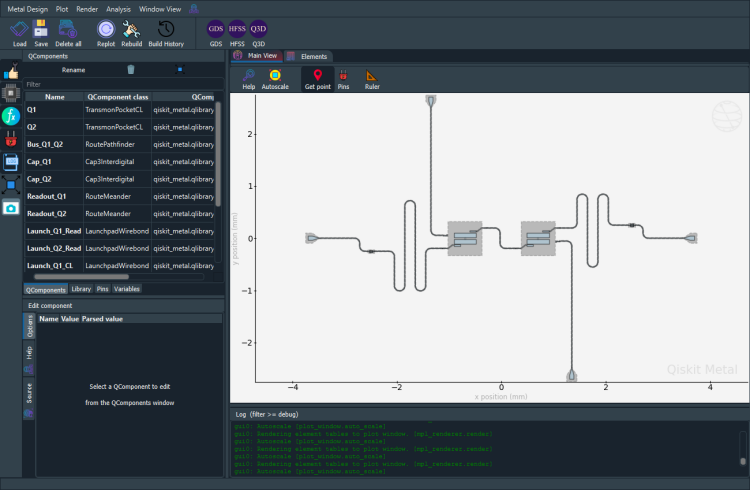

In [15]:
gui.screenshot()

## Simulation and Analysis

With our fully designed chip now laid out, we can start to focus on tuning the components to hit the circuit parameters we are interested in. These will tend to be;
- qubit: frequency, the anharmonicity/alpha, and the coupling strength (as chi, g, or other)
- busses: frequency (if resonant), the coupling strength
- readout: frequency, coupling strength, coupling to external lines (as kappa, Q_external, or other)

### Analysis via capacitance matrix and LOM

All of the qubit paramters can initially be tuned via a capacitance matrix and the lumped oscillator method. This analysis is not as accurate as others, but allows for fairly fast and small simulations.

We will start by selecting the Analysis class of interest.

In [16]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

We can see what options are available for the analysis and make any changes we may wish, such as increasing the buffer size for the bounding box when simulation subsections of the chip.

In [17]:
sim_p = c1.setup.sim

In [18]:
sim_p.name = 'QubitTune'
sim_p.max_passes = 15
sim_p.min_converged_passes = 2
sim_p.percent_error = 0.1

c1.setup.sim

{'name': 'QubitTune',
 'reuse_selected_design': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.1,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

With the design and simulation setup, we render the qubit. For LOM analysis, we want the connection pads to be terminated with opens. We indicate this by stating which unconnected pins should have open terminations.

*During the execution of the next cell, make sure to deal with any pop up boxes from Ansys as it opens up (if it was closed)*

In [19]:
c1.run_sim(name="Qubit1", components=['Q1'], open_terminations=[('Q1', 'readout'), ('Q1', 'bus')])

INFO 03:58PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:58PM [load_ansys_project]: 	Opened Ansys App
INFO 03:58PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:58PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project21
INFO 03:58PM [connect_design]: No active design found (or error getting active design).
INFO 03:58PM [connect]: 	 Connected to project "Project21". No design detected
INFO 03:58PM [connect_design]: 	Opened active design
	Design:    Qubit1_q3d [Solution type: Q3D]
WARNING 03:58PM [connect_setup]: 	No design setup detected.
WARNING 03:58PM [connect_setup]: 	Creating Q3D default setup.
INFO 03:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:58PM [get_setup]: 	Opened setup `QubitTune`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:58PM [analyze]: Analyzing setup QubitTune
INFO 04:00PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp07p_amft.txt, C, , QubitTune:Last

('Qubit1_q3d', 'QubitTune')

Once complete, we can grab the capacitance matrix (next cell) and/or (following cells) call on an LOM analysis of the simulation.

In [20]:
c1.capacitance_matrix

,bus_connector_pad_Q1,cl_metal_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus_connector_pad_Q1,50.95742,-0.01089,-34.52330,-13.79066,-1.64529,-0.13818
cl_metal_Q1,-0.01089,16.46410,-15.96926,-0.22646,-0.13073,-0.05208
ground_main_plane,-34.52330,-15.96926,223.36651,-39.67777,-39.72940,-34.47648
pad_bot_Q1,-13.79066,-0.22646,-39.67777,90.65814,-32.51147,-1.65442
pad_top_Q1,-1.64529,-0.13073,-39.72940,-32.51147,90.64021,-13.79226
readout_connector_pad_Q1,-0.13818,-0.05208,-34.47648,-1.65442,-13.79226,50.96623


In [21]:
c1.setup.lom.junctions = Dict({'Lj': 14, 'Cj': 2})
c1.setup.lom.freq_readout = 7.0
c1.setup.lom.freq_bus = [0.1, 0.1]  # list of the bus frequencies

c1.run_lom()
c1.lumped_oscillator_all

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.061492 [GHz]
EC 311.552639 [MHz]
EJ 11.671114 [GHz]
alpha -368.257008 [MHz]
dispersion 121.977490 [KHz]
Lq 13.994355 [nH]
Cq 62.173211 [fF]
T1 146.271198 [us]

**Coupling Properties**

tCqbus1 -6.072524 [fF]
gbus1_in_MHz -91.062961 [MHz]
χ_bus1 -1.409124 [MHz]
1/T1bus1 1088.080950 [Hz]
T1bus1 146.271234 [us]

tCqbus2 6.069084 [fF]
gbus2_in_MHz 1.306166 [MHz]
χ_bus2 -0.000106 [MHz]
1/T1bus2 0.000267 [Hz]
T1bus2 597009419.268721 [us]

tCqbus3 0.047782 [fF]
gbus3_in_MHz 0.010284 [MHz]
χ_bus3 -0.000000 [MHz]
1/T1bus3 0.000000 [Hz]
T1bus3 9630489925176.917969 [us]
Bus-Bus Couplings
gbus1_2 0.100268 [MHz]
gbus1_3 0.004459 [MHz]
gbus2_3 0.000039 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.433479,363.151528,11.671114,-437.336534,413.329185,"[-83.70370737679436, 1.1092096840330103, 0.021...","[-1.993320614783169, -7.937274989564146e-05, -...",1.993321,83.703707
2,5.374225,354.619592,11.671114,-425.74452,344.26075,"[-85.86624225980508, 1.211649830440972, 0.0110...","[-1.9247581177568647, -9.411667597472957e-05, ...",1.924758,85.866242
3,5.294418,343.317179,11.671114,-410.493535,267.338562,"[-86.81301268012994, 1.2269028182125488, 0.009...","[-1.7567100537167433, -9.569833756789184e-05, ...",1.756710,86.813013
4,5.237437,335.37911,11.671114,-399.85287,222.102742,"[-86.00764071064755, 1.2118346943155938, 0.010...","[-1.592938999879478, -9.281432404608038e-05, -...",1.592939,86.007641
5,5.187715,328.541365,11.671114,-390.733249,188.289786,"[-87.25648878074503, 1.2319505330464855, 0.010...","[-1.531638636164018, -9.543495388547847e-05, -...",1.531639,87.256489
6,5.149093,323.287145,11.671114,-383.754316,165.248445,"[-87.48765521103682, 1.2552596841073371, 0.010...","[-1.4614004711797408, -9.869336509104824e-05, ...",1.461400,87.487655
7,5.125129,320.051895,11.671114,-379.469406,152.23832,"[-88.79498644396803, 1.2704383982971335, 0.010...","[-1.4577871335476382, -0.0001008507924839105, ...",1.457787,88.794986
8,5.105116,317.364567,11.671114,-375.917292,142.075811,"[-89.18853692318046, 1.2794460462997506, 0.010...","[-1.4320055861053953, -0.00010208074169171004,...",1.432006,89.188537
9,5.093596,315.82365,11.671114,-373.883403,136.502239,"[-89.73318814854198, 1.285204872031634, 0.0102...","[-1.4275386280297915, -0.00010288308401178529,...",1.427539,89.733188
10,5.084156,314.564326,11.671114,-372.222761,132.080543,"[-89.78419887891071, 1.2900134958855947, 0.010...","[-1.4114037374706405, -0.00010355673717275049,...",1.411404,89.784199


We can finally observe how the main quantum parameters have converged after the previous simulation.

In [22]:
c1.plot_convergence();
c1.plot_convergence_chi()

INFO 04:00PM [hfss_report_full_convergence]: Creating report for variation 0


Design "Qubit1_q3d" info:
	# eigenmodes    0
	# variations    1


Note that it is possible for a (physically) converged simulation, to not have quite converged in the quantum realm.

Looking at the convergence plots from the previous cell, we can see that we did not have enough passes for the simulation. In this case, we want to modify our simulation setup, 'QubitTune', to improve our convergence (increase number of passes, or changing some other parameters).

Once we will know that simulation has converged, we can use those results to make appropriate changes to our qubit layout. Say our anharmonicity/alpha is higher than we want? Since we know Ec~ 1/C, we can change parts of the transmon pocket to lower the total capacitance seen across the junction.
If g to the bus is too low, we can increase the width of the connection pad so that the capacitance between the connection pad and charge island is greater.

One must also keep in mind that any such changes will impact the other parameters, so careful tweaks and iterations of simulation/analysis often end up being necessary.

If wanting to make changes and re-render your design, you first should clear your current design.

In [23]:
c1.renderer.clean_active_design()

When done with all the simulations, you can disconnect from Ansys EDT.

In [24]:
c1.close()

### Analysis via eigenmode and EPR

Now, although the previous simulation and analysis captured all of the parameters of the qubits and coupling to the bus, a more accurate (all be it slower) approach is to render the qubits and their coupling into an eigenmode simulation and perform EPR analysis on the result.

We again start by selecting the Analysis class of interest.

In [25]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qb = EPRanalysis(design, "hfss")

Review and update the simulation setup by executing following two cells.

In [26]:
em_p = eig_qb.setup.sim

In [27]:
em_p.name = 'QubitTune'
em_p.min_freq_ghz = 3
em_p.n_modes = 2
em_p.max_passes = 12
em_p.max_delta_f = 0.1
em_p.min_converged = 2
# Design variables can also be added in for direct simulation sweeps.
em_p.vars = Dict({'Lj1': '14 nH', 'Cj1': '0 fF', 'Lj2': '12 nH', 'Cj2': '0 fF'})

eig_qb.setup.sim

{'name': 'QubitTune',
 'reuse_selected_design': True,
 'min_freq_ghz': 3,
 'n_modes': 2,
 'max_delta_f': 0.1,
 'max_passes': 12,
 'min_passes': 1,
 'min_converged': 2,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj1': '14 nH', 'Cj1': '0 fF', 'Lj2': '12 nH', 'Cj2': '0 fF'}}

We can now run the simulation on the specified layout.

In [28]:
eig_qb.run_sim(name="Q1_Q2_Bus", components=['Bus_Q1_Q2', 'Q1', 'Q2'], open_terminations=[])

INFO 04:01PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:01PM [load_ansys_project]: 	Opened Ansys App
INFO 04:01PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 04:01PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project21
INFO 04:01PM [connect_design]: 	Opened active design
	Design:    Qubit1_q3d [Solution type: Q3D]
INFO 04:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:01PM [connect]: 	Connected to project "Project21" and design "Qubit1_q3d" 😀 

INFO 04:01PM [connect_design]: 	Opened active design
	Design:    Q1_Q2_Bus_hfss [Solution type: Eigenmode]
WARNING 04:01PM [connect_setup]: 	No design setup detected.
WARNING 04:01PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:01PM [get_setup]: 	Opened setup `QubitTune`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:01PM [analyze]: Analyzin

('Q1_Q2_Bus_hfss', 'QubitTune')

Once completed, we can check the convergence to see if more passes might be necessary.

In [29]:
eig_qb.plot_convergences()

This eigenmode simulation is also a quick method to check for any bus or readout resonator frequencies. 
If happy with the simulation, we can then jump to some EPR analysis.

At first we need to define the junctions in terms of name, inductance_variable, capacitance_variable, rectancle that was defined in the rendering to represent the junction `port` and line that was defined in the rendering to represent the direction of the current thorugh the junction.

In [30]:
eig_qb.del_junction()
eig_qb.add_junction('jj1', 'Lj1', 'Cj1', rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_')
eig_qb.add_junction('jj2', 'Lj2', 'Cj2', rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_')
eig_qb.setup.epr.sweep_variable = 'Lj1'
eig_qb.setup.epr

{'junctions': {'jj1': {'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'},
  'jj2': {'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2',
   'rect': 'JJ_rect_Lj_Q2_rect_jj',
   'line': 'JJ_Lj_Q2_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

Note in the previous cell output that the dissipatives have alrady been defined by default.

Now we can start looking at the EPR values. First we look at the electric field and subtrate participation.

In [31]:
eig_qb.run_epr()
# (pyEPR allows to switch modes: eprd.set_mode(1))

Design "Q1_Q2_Bus_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Q1_Q2_Bus_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 1.07745203911283e-24
        energy_elec_substrate = 9.92850687215031e-25
        EPR of substrate = 92.1%

        energy_mag    = 4.1725878513546e-27
        energy_mag % of energy_elec_all  = 0.4%
        

Variation 0  [1/1]

  Mode 0 at 5.36 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.6%  5.387e-25 2.086e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.92%
	jj1             0.995219  (+)        0.0315956
		Energy fraction (Lj over Lj&Cj)= 97.35%
	jj2             3.89107e-05  (+)        1.05884e-06
		(U_tot_cap-U_tot_ind)/mean=1.60%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9214

WARNING 04:04PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project21\Q1_Q2_Bus_hfss\2021-07-08 16-04-11.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.032559
1    1.032902
dtype: float64

Pm_norm idx =
     jj1    jj2
0   True  False
1  False   True
*** P (participation matrix, not normlz.)
        jj1       jj2
0  0.964736  0.000038
1  0.000039  0.963814

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1      1
1      1      1
*** P (participation matrix, normalized.)
         1  3.8e-05
   3.9e-05        1

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       305   0.0469
    0.0469      304

*** Chi matrix ND (MHz) 
       346    0.888
     0.888      341

*** Frequencies O1 PT (MHz)
0    5054.004629
1    5479.644732
dtype: float64

*** Frequencies ND (MHz)
0    5034.020336
1    5461.521809
dtype:

TypeError: epr_report_hamiltonian() takes from 1 to 2 positional arguments but 3 were given

From the analysis results we can determine the qubits anharmonicities and coupling strength.

Other analysis is still being added, such as the impedance analysis, though some already be done manually by renderering to a driven modal simulation and performing frequency sweeps to extract the S-Parameters or Impedance matrix. This would be an easy way to, say, determine the external quality factor of a readout resonator. *See tutorial notebooks 4.3*

Once the analysis and tuning is complete, we can disconnect from the renderer.

In [ ]:
eig_qb.close()

### Rendering to a GDS File

Once all of the tuning is complete, we will want to prepare a GDS file so we can create a mask and fabricate our chip. We first create a gds render instance.

In [ ]:
qhk21_gds = design.renderers.gds

The various options for the gds renderer can be checked and changed as necessary. A key option is the gds file which holds the cells for your junction ebeam design. Make sure this is pointing at the correct file so they are placed in your final mask at the appropriate locations.

In [ ]:
qhk21_gds.options

In [ ]:
qhk21_gds.options['path_filename'] = '../resources/Fake_Junctions.GDS'
qhk21_gds.options['no_cheese']['buffer']='50um'

In [ ]:
qhk21_gds.export_to_gds('QHK21_Tutorial.gds')

(optional) Now that the design is finished, we can close the GUI.

In [ ]:
# gui.main_window.close()